# Tuning Up TWPA:

---

## To Do:

- config from data file
- order of looping
- line plots from heatmap
- 2D peak finder
    - high SNR
    - clustered high
- automated script


## Idea:


1. Method to average the 2D color plots 
    a. Store the averaged plots
2. Method to calculate SNR from Signal
3. For each pump frequency:
    For each point on averaged plots:
        a. calculate SNR
        b. extract regions of stable high SNR
4. Create 3D plot with color = SNR, and <x = pump freq., y = pump power, z  = SNR>
5. Extract points (x,y,z) with stable high SNR!

## For Scripting:

- [SNR Code](#snr)


In [1]:
import Labber
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy.signal import find_peaks, peak_prominences, peak_widths
from fitTools.utilities import Watt2dBm, dBm2Watt, VNA2dBm

/Users/shanto/miniforge3/envs/lfl_qp/lib/python3.9/site-packages/qtpy/__init__.py:214: RuntimeWarning: Selected binding "pyqt5" could not be found, using "pyside6"
  warnings.warn('Selected binding "{}" could not be found, '


# Data File Structure 

In [2]:
TWPA0919 = "data/TWPA_Tune_Up_91923.hdf5"
lf = Labber.LogFile(TWPA0919)

In [3]:
SA_channel_name = 'HP Spectrum Analyzer - Signal'

In [4]:
signal = lf.getData(name = SA_channel_name)
signal

array([[-66.24, -67.54, -68.25, ..., -72.88, -66.55, -67.97],
       [-66.81, -66.2 , -65.71, ..., -68.02, -70.23, -65.64],
       [-67.88, -67.47, -68.3 , ..., -68.21, -68.25, -68.95],
       ...,
       [-70.88, -68.02, -67.72, ..., -67.93, -65.05, -64.98],
       [-73.33, -69.62, -68.07, ..., -66.74, -65.07, -65.24],
       [-71.3 , -67.07, -66.55, ..., -65.14, -70.49, -69.8 ]])

In [5]:
signal.shape

(3040, 401)

In [6]:
linsig = dBm2Watt(signal)
linsig.shape

(3040, 401)

In [7]:
SAxdata, SAydata = lf.getTraceXY(y_channel=channel_name) # gives last trace from SA

In [8]:
#plt.style.use('science')

Text(0.5, 0, 'Frequency (GHz)')

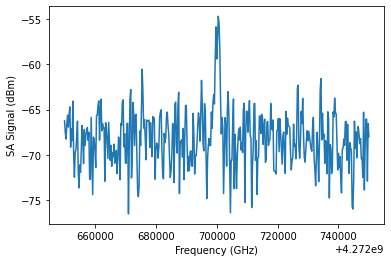

In [9]:
plt.plot(SAxdata, signal[0])
plt.ylabel("SA Signal (dBm)")
plt.xlabel("Frequency (GHz)")

Text(0.5, 0, 'Frequency (GHz)')

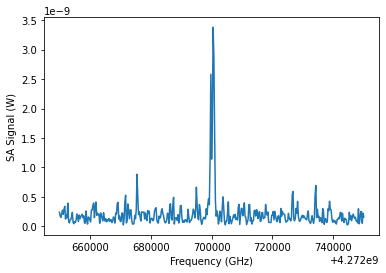

In [10]:
plt.plot(SAxdata, linsig[0])
plt.ylabel("SA Signal (W)")
plt.xlabel("Frequency (GHz)")

# Calculating SNR

### Finding Peaks

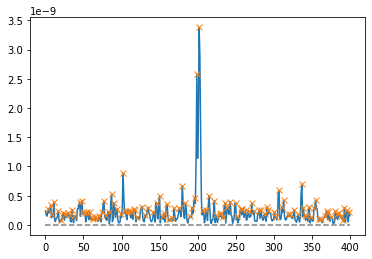

In [62]:
peaks, peak_prop = find_peaks(linsig[0])
plt.plot(linsig[0])
plt.plot(peaks, linsig[0][peaks], "x")
plt.plot(np.zeros_like(linsig[0]), "--", color="gray")
plt.show()

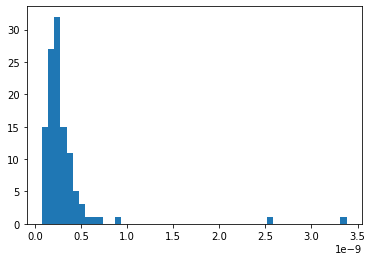

In [101]:
all_data = linsig[0][peaks]

plt.hist(all_data,bins=50)
plt.show()

In [98]:
def outliers_removed(arr, std_dev=2):
    mean = np.mean(arr)
    standard_deviation = np.std(arr)
    distance_from_mean = abs(arr - mean)
    max_deviations = std_dev
    not_outlier = distance_from_mean < max_deviations * standard_deviation
    no_outliers = arr[not_outlier]
    return no_outliers

In [103]:
noise_data = outliers_removed(linsig[0][peaks])
noise_data.mean()

2.6168371657730023e-10

In [110]:
max(all_data)

3.3806483620598154e-09

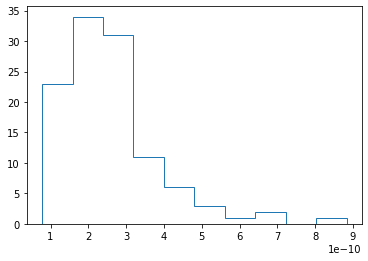

In [107]:
plt.hist(noise_data,histtype="step")
plt.show()

In [108]:
snr = Watt2dBm(max(all_data)) - Watt2dBm(noise_data.mean())
snr

11.112233007481358

<a id='snr'></a>

### SNR Code

In [112]:
def outliers_removed(arr, std_dev=2):
    mean = np.mean(arr)
    standard_deviation = np.std(arr)
    distance_from_mean = abs(arr - mean)
    max_deviations = std_dev
    not_outlier = distance_from_mean < max_deviations * standard_deviation
    no_outliers = arr[not_outlier]
    return no_outliers

def get_signal_stats(linsig,std_dev=2):
    """
    inputs: (linsig:: array (SA Signal in Watts), std_dev:: int (cut off for outlier)
    returns: [float, float, float] :: [snr, signal_max, average_noise_floor] (all in dBm)
    """
    peaks, peak_prop = find_peaks(linsig)
    all_data = linsig[peaks]
    noise_data = outliers_removed(linsig[peaks],std_dev)
    noise_floor = Watt2dBm(noise_data.mean())
    max_signal = Watt2dBm(max(all_data))
    snr = max_signal - noise_floor
    return [snr, max_signal, noise_floor]
    

In [113]:
get_signal_stats(linsig[0])

[11.112233007481358, -54.71, -65.82223300748136]

# Combining Various Traces at Same Configurations 

For the data file we are dealing with we have used the following external parameters.

```
repeated = 4 # per config
power_range = 10
freq_range = 76
```

This explains the data structure of the signal `(3040, 401) = (4*10*76, 401)`. `401` is the fidelity of the Spectrum Analyzer and stays constant in between measurements and the breakdown `4*10*76` is how we took our measurements.


![measurement](measurement.png)

From looking at the LogBrowser. It is obvious how the config works.

![traces](traces.png)

Logic of Trace is as follows:

```python

for freq in range(freq_range):
    for power in range(power_range):
        for repeat in range(repeated): 

```

**LOOPS IN MEASUREMENT WINDOW GO FROM INNER MOST TO OUTERMOST IN ORDER**

In [117]:
repeated = 4
power_range = 10
freq_range = 76
freq_range * power_range * repeated

3040

In [237]:
power_channel_name = "10002F25 - Power"
freq_channel_name = "10002F25 - Frequency"

pump_power = lf.getData(name = power_channel_name)
pump_freq = lf.getData(name = freq_channel_name)

In [119]:
pump_power.shape

(760, 4)

In [120]:
pump_freq.shape

(760, 4)

In [427]:
pump_power

array([[0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [2., 2., 2., 2.],
       ...,
       [7., 7., 7., 7.],
       [8., 8., 8., 8.],
       [9., 9., 9., 9.]])

In [124]:
pump_freq

array([[7.0e+09, 7.0e+09, 7.0e+09, 7.0e+09],
       [7.0e+09, 7.0e+09, 7.0e+09, 7.0e+09],
       [7.0e+09, 7.0e+09, 7.0e+09, 7.0e+09],
       ...,
       [8.5e+09, 8.5e+09, 8.5e+09, 8.5e+09],
       [8.5e+09, 8.5e+09, 8.5e+09, 8.5e+09],
       [8.5e+09, 8.5e+09, 8.5e+09, 8.5e+09]])

In [126]:
signal.shape

(3040, 401)

In [127]:
signal

array([[-66.24, -67.54, -68.25, ..., -72.88, -66.55, -67.97],
       [-66.81, -66.2 , -65.71, ..., -68.02, -70.23, -65.64],
       [-67.88, -67.47, -68.3 , ..., -68.21, -68.25, -68.95],
       ...,
       [-70.88, -68.02, -67.72, ..., -67.93, -65.05, -64.98],
       [-73.33, -69.62, -68.07, ..., -66.74, -65.07, -65.24],
       [-71.3 , -67.07, -66.55, ..., -65.14, -70.49, -69.8 ]])

General formula for taking the average of $r$ rows for a 2D array $a$ with $c$ columns:

`a.transpose().reshape(-1,r).mean(1).reshape(c,-1).transpose()`

In [154]:
average_signal = signal.transpose().reshape(-1,repeated).mean(1).reshape(signal.shape[-1],-1).transpose()

In [155]:
average_signal.shape

(760, 401)

In [ ]:
np.reshape(average_signal, ()) 

In [250]:
average_lin_signal = dBm2Watt(average_signal)

In [389]:
pump_freqs = np.linspace(pump_freq[0][0],pump_freq[-1][-1],freq_range)
pump_freqs

array([7.00e+09, 7.02e+09, 7.04e+09, 7.06e+09, 7.08e+09, 7.10e+09,
       7.12e+09, 7.14e+09, 7.16e+09, 7.18e+09, 7.20e+09, 7.22e+09,
       7.24e+09, 7.26e+09, 7.28e+09, 7.30e+09, 7.32e+09, 7.34e+09,
       7.36e+09, 7.38e+09, 7.40e+09, 7.42e+09, 7.44e+09, 7.46e+09,
       7.48e+09, 7.50e+09, 7.52e+09, 7.54e+09, 7.56e+09, 7.58e+09,
       7.60e+09, 7.62e+09, 7.64e+09, 7.66e+09, 7.68e+09, 7.70e+09,
       7.72e+09, 7.74e+09, 7.76e+09, 7.78e+09, 7.80e+09, 7.82e+09,
       7.84e+09, 7.86e+09, 7.88e+09, 7.90e+09, 7.92e+09, 7.94e+09,
       7.96e+09, 7.98e+09, 8.00e+09, 8.02e+09, 8.04e+09, 8.06e+09,
       8.08e+09, 8.10e+09, 8.12e+09, 8.14e+09, 8.16e+09, 8.18e+09,
       8.20e+09, 8.22e+09, 8.24e+09, 8.26e+09, 8.28e+09, 8.30e+09,
       8.32e+09, 8.34e+09, 8.36e+09, 8.38e+09, 8.40e+09, 8.42e+09,
       8.44e+09, 8.46e+09, 8.48e+09, 8.50e+09])

In [381]:
pump_powers = np.linspace(pump_power[0][0],pump_power[-1][-1],power_range)
pump_powers

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [398]:
np.meshgrid(pump_powers, pump_freqs)

[array([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],


In [446]:
SNRs = []
max_signals = []
noise_floors = []

#for j, freq in enumerate(pump_freqs):
#    for i, power in enumerate(pump_powers):
        #snrs, max_signal, noise_floor = get_signal_stats(average_lin_signal)
        #print(i,j)
        
for signal in average_lin_signal:
    snrs, max_signal, noise_floor = get_signal_stats(signal,std_dev=2.5)
    SNRs.append(snrs)
    max_signals.append(max_signal)
    noise_floors.append(noise_floor)

SNRs = np.array(SNRs)
max_signals = np.array(max_signals)
noise_floors = np.array(noise_floors)

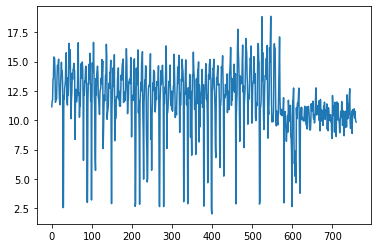

In [447]:
plt.plot(SNRs)

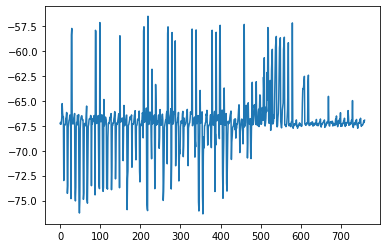

In [448]:
plt.plot(noise_floors)

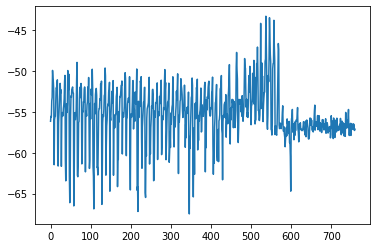

In [449]:
plt.plot(max_signals)

In [450]:
SNRs_reshaped = np.reshape(SNRs, (power_range,freq_range))
SNRs_reshaped.shape

(10, 76)

In [451]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
from matplotlib.ticker import LinearLocator, FormatStrFormatter

Text(0, 0.5, 'SNR')

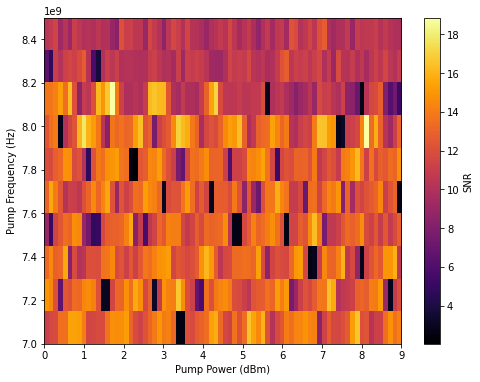

In [452]:
%matplotlib inline

heatmap, ax = plt.subplots(figsize=(8,6))

im = ax.imshow(SNRs_reshaped,cmap='inferno',extent=[pump_powers[0],pump_powers[-1],pump_freqs[0],pump_freqs[-1]],interpolation='nearest',origin='lower',aspect='auto')

ax.set(xlabel='Pump Power (dBm)', ylabel='Pump Frequency (Hz)')
cbar = heatmap.colorbar(im)
cbar.ax.set_ylabel('SNR')

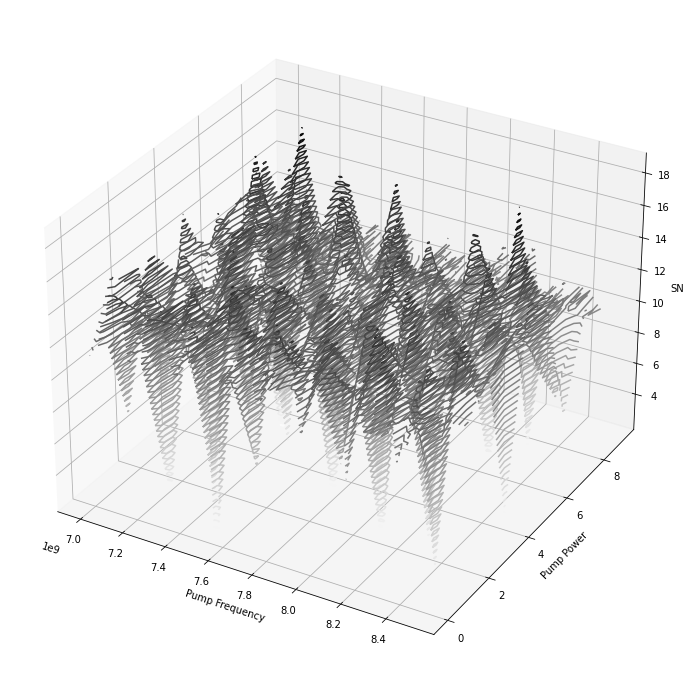

In [453]:
from mpl_toolkits import mplot3d

Y = pump_powers
X = pump_freqs
Z = SNRs_reshaped
fig = plt.figure(figsize=(12,16))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('Pump Frequency')
ax.set_ylabel('Pump Power')
ax.set_zlabel('SNR');

In [454]:
%matplotlib qt

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

# Extracting Regions of High SNR

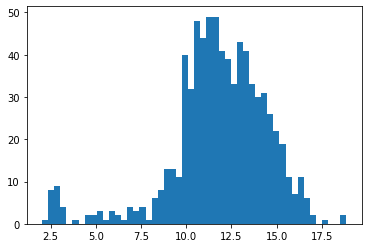

In [455]:
%matplotlib inline

plt.hist(SNRs,bins=50)
plt.show()

(array([36.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  5.,  2.,  4.,  5.,  9., 12., 15., 12.,
        47., 46., 49., 55., 51., 44., 46., 37., 51., 45., 33., 38., 31.,
        23., 22., 12., 11., 10.,  4.,  1.,  0.,  1.,  0.,  2.]),
 array([ 0.        ,  0.37729843,  0.75459687,  1.1318953 ,  1.50919373,
         1.88649217,  2.2637906 ,  2.64108903,  3.01838747,  3.3956859 ,
         3.77298433,  4.15028277,  4.5275812 ,  4.90487963,  5.28217807,
         5.6594765 ,  6.03677493,  6.41407336,  6.7913718 ,  7.16867023,
         7.54596866,  7.9232671 ,  8.30056553,  8.67786396,  9.0551624 ,
         9.43246083,  9.80975926, 10.1870577 , 10.56435613, 10.94165456,
        11.318953  , 11.69625143, 12.07354986, 12.4508483 , 12.82814673,
        13.20544516, 13.5827436 , 13.96004203, 14.33734046, 14.7146389 ,
        15.09193733, 15.46923576, 15.8465342 , 16.22383263, 16.60113106,
        16.9784295 , 17.35572793, 17.73302636, 18.1103248 ,

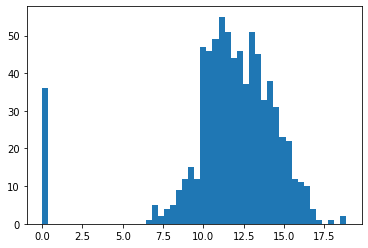

In [456]:
new_arr = get_2d_array_N_std_greater_than_mean(SNRs, std_dev=-2)
plt.hist(new_arr, bins=50)

In [457]:
def get_2d_array_N_std_greater_than_mean(arr, std_dev=2):
    mean = np.mean(arr)
    standard_deviation = np.std(arr)
    distance_from_mean = abs(arr - mean)
    
    min_deviations = std_dev
    high_values = mean + min_deviations * standard_deviation
    #print(high_values)
    
    new_array = np.where(arr < high_values, 0, arr)
    return new_array

def get_config_for_high_SNR(arr,x,y,std_dev=2):
    mean = np.mean(arr)
    standard_deviation = np.std(arr)
    distance_from_mean = abs(arr - mean)
    
    min_deviations = std_dev
    high_values = mean + min_deviations * standard_deviation
    
    mask = (arr > high_values)
    indices = np.where(mask)
    
    snrs = arr[indices]
    xvals = x[indices[0]]
    yvals = y[indices[1]]
    
    return list(zip(xvals,yvals,snrs))

def get_index_for_high_SNR(arr,x,y,std_dev=2):
    mean = np.mean(arr)
    standard_deviation = np.std(arr)
    distance_from_mean = abs(arr - mean)
    
    min_deviations = std_dev
    high_values = mean + min_deviations * standard_deviation
    
    mask = (arr > high_values)
    indices = np.where(mask)

    return indices

In [458]:
get_config_for_high_SNR(SNRs_reshaped,x=pump_powers, y=pump_freqs,std_dev=1.75)

[(0.0, 7860000000.0, 16.549866637199727),
 (0.0, 8320000000.0, 16.608943619218152),
 (1.0, 7560000000.0, 16.641488971014375),
 (6.0, 7160000000.0, 17.754057714765636),
 (6.0, 7560000000.0, 16.967961710624067),
 (6.0, 8360000000.0, 18.825572252895668),
 (7.0, 7260000000.0, 16.661992804837475),
 (7.0, 7280000000.0, 18.86492166172537),
 (7.0, 7720000000.0, 17.103504653621265)]

In [246]:
def get_pump_power_and_frequency(pump_power,pump_freq,power_range,freq_range):
    """
    inputs:
        - pump_power from Labber
        - pump_freq from Labber
        - # of power points
        - # of frequency points
    returns:
        - pump_power ,  pump_freq (all 1D arr)
    """
    pump_freqs = np.linspace(pump_freq[0][0],pump_freq[-1][-1],freq_range)
    pump_powers = np.linspace(pump_power[0][0],pump_power[-1][-1],power_range)
    return pump_powers, pump_freqs

def get_column_from_2d_array(arr, n=0):
    """
    returns the nth column of the 2D array, arr
    """
    return arr[:,n]

def get_average_of_N_traces(signal, N):
    """
    inputs:
        - signal -> 2D array: from Labber Log File
        - N -> int: number of time a trace was taken for each config
    return:
        - averaged signal -> reduced 2D array
    """
    return signal.transpose().reshape(-1,N).mean(1).reshape(signal.shape[-1],-1).transpose()